# Introduction 
When started working on customer lifetime value (CLV), I was overwhelmed by the various ways to calculate CLVs. For instance, there are RFM based and cohort based CLV. Also, the CLV formulas may differ depending on whether customer pays before or after receiving services.

Insterested reader may watch https://www.youtube.com/watch?v=guj2gVEEx4s and https://www.coursera.org/lecture/uva-darden-market-analytics/extending-the-clv-formula-part-1-WvSKb for references.

The following approach is based on https://gormanalysis.com/practical-guide-to-calculating-customer-lifetime-value-clv/ and https://optimizationup.com/cohort-analysis-performance-marketing/, which is called Historical CLV.
    
Let us take a look at data.

In [1]:
import pandas as pd
data = pd.read_csv('C:/data/LTV_by_cohort.csv')
data.head()

,increment_id,status,created_at,customer_id,gross_order_revenue
0,200095401,complete,2/1/2015 2:53,1000477,74.95
1,200095423,complete,2/1/2015 6:04,1000478,84.95
2,200095430,complete,2/1/2015 6:55,1000479,220.89
3,200095436,complete,2/1/2015 7:41,1000480,182.99
4,200095440,complete,2/1/2015 8:03,1000481,32.99


# Exploratory Data Analysis

# Check whether there are duplications of IDs

In [2]:
print(data.increment_id.count())
print(data.increment_id.nunique())

21597
21597


In [3]:
print(data.customer_id.count())
print(data.customer_id.nunique())

21597
17036


# Check whether there exists incomplete status

In [4]:
print(data.status.value_counts())

complete    21597
Name: status, dtype: int64


# Check if there are negative values of revenues

In [5]:
data.gross_order_revenue.describe()

count    21597.000000
mean       187.958897
std        284.424828
min          0.000000
25%         54.950000
50%        105.000000
75%        205.950000
max       7496.950000
Name: gross_order_revenue, dtype: float64

# Check if there are missing values

In [6]:
data.isnull().values.any()

False

# Check if there are NA values

In [7]:
data.isna().values.any()

False

# Calculatinig average gross revenue and historical CLV
The procedure is the same as in Customer_Retention_Rate.ipynb.

In [8]:
data['date'] = data.created_at.str.split(expand=True)[0]
data['datetime'] =  pd.to_datetime(data['date'], format='%m/%d/%Y')
data['OrderMonth'] = data.datetime.dt.to_period('M').astype(str)
data['Cohort'] = data.groupby('customer_id')['OrderMonth'].transform(min)

grouped = data.groupby(['Cohort', 'OrderMonth'])
# customer_id and gross_order_revenue in cohorts do not represent original meaning
cohorts = grouped.agg({'customer_id': pd.Series.nunique,
                       'gross_order_revenue': 'sum'})

cohorts['gross_cum_revenue'] = cohorts.groupby('Cohort')['gross_order_revenue'].cumsum()
cohorts.rename(columns={'customer_id': 'total_customers',
                        'gross_order_revenue': 'total_revenue',
                        'gross_cum_revenue': 'cum_revenue'}, inplace=True)
cohorts['initial_customers'] = cohorts.groupby('Cohort')['total_customers'].transform(max)

cohort_group_size = cohorts['total_customers'].groupby(level=0).first()
cohorts.head(15)

total_customers  total_revenue  cum_revenue  \
Cohort  OrderMonth                                                
2015-02 2015-02                 879      158479.85    158479.85   
        2015-03                  21        2851.21    161331.06   
        2015-04                  25        4877.02    166208.08   
        2015-05                  25        5117.84    171325.92   
        2015-06                  17        3279.42    174605.34   
        2015-07                  16        2562.26    177167.60   
        2015-08                  16        4060.46    181228.06   
        2015-09                  14        2139.31    183367.37   
        2015-10                  13        3885.19    187252.56   
        2015-11                  39        6473.58    193726.14   
        2015-12                  57        9539.41    203265.55   
        2016-01                  26        5739.68    209005.23   
        2016-02                  52        6992.58    215997.81   
        2016-03                  23        5193.11    221190.92   
2015-03 2015-03                 709      127847.91    127847.91   

                    initial_customers  
Cohort  OrderMonth                     
2015-02 2015-02                   879  
        2015-03                   879  
        2015-04                   879  
        2015-05                   879  
        2015-06                   879  
        2015-07                   879  
        2015-08                   879  
        2015-09                   879  
        2015-10                   879  
        2015-11                   879  
        2015-12                   879  
        2016-01                   879  
        2016-02                   879  
        2016-03                   879  
2015-03 2015-03                   709

In [9]:
Revenue = cohorts['cum_revenue'].unstack(0)
Revenue

Cohort,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03
OrderMonth,,,,,,,,,,,,,,
2015-02,158479.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,161331.06,127847.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,166208.08,130332.63,150661.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05,171325.92,131903.79,155751.04,172499.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06,174605.34,134687.40,158720.44,175665.43,130997.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07,177167.60,136788.61,162337.75,177734.03,134533.34,139543.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,181228.06,137863.91,166173.55,181051.24,136561.35,144648.16,130123.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,183367.37,141038.64,168596.42,182875.23,137496.31,146658.19,134469.36,180354.62,NaN,NaN,NaN,NaN,NaN,NaN
2015-10,187252.56,143785.47,169696.78,184259.50,139224.28,149211.10,138263.59,186809.25,172317.60,NaN,NaN,NaN,NaN,NaN


In [10]:
Initial_Customers = cohorts['initial_customers'].unstack(0)
Initial_Customers

Cohort,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03
OrderMonth,,,,,,,,,,,,,,
2015-02,879.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,879.0,709.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,879.0,709.0,746.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05,879.0,709.0,746.0,817.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06,879.0,709.0,746.0,817.0,632.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07,879.0,709.0,746.0,817.0,632.0,755.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,879.0,709.0,746.0,817.0,632.0,755.0,685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,879.0,709.0,746.0,817.0,632.0,755.0,685.0,727.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-10,879.0,709.0,746.0,817.0,632.0,755.0,685.0,727.0,803.0,NaN,NaN,NaN,NaN,NaN


In [11]:
historical_CLV = Revenue / Initial_Customers
historical_CLV

Cohort,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03
OrderMonth,,,,,,,,,,,,,,
2015-02,180.295620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,183.539317,180.321453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,189.087691,183.825994,201.959424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05,194.910034,186.042017,208.781555,211.137589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06,198.640887,189.968124,212.761984,215.012766,207.275032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07,201.555859,192.931749,217.610925,217.544712,212.869209,184.825907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,206.175267,194.448392,222.752748,221.604945,216.078085,191.586967,189.961985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,208.609067,198.926150,226.000563,223.837491,217.557453,194.249258,196.305635,248.080633,NaN,NaN,NaN,NaN,NaN,NaN
2015-10,213.029078,202.800381,227.475576,225.531824,220.291582,197.630596,201.844657,256.959078,214.592279,NaN,NaN,NaN,NaN,NaN


([<matplotlib.axis.XTick at 0x1fba2f062e8>,
 <a list of 13 Text xticklabel objects>)

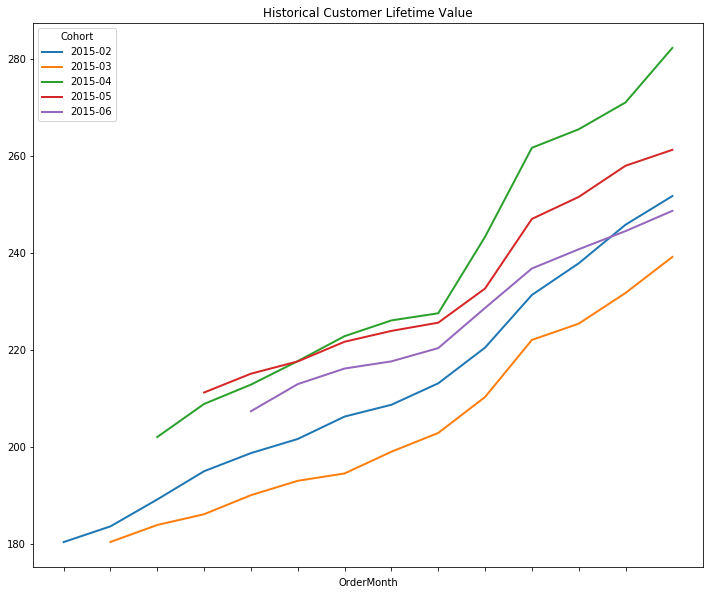

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

historical_CLV[['2015-02', '2015-03', '2015-04', '2015-05', '2015-06']].plot(figsize=(12,10))
plt.title('Historical Customer Lifetime Value')
plt.xticks(range(0,13))